# Titanic Logistic Regression
<hr/>

In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 

<img src = './titanic-disaster.jpg'><img>

In [385]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [386]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Data Dictionary

   - Survival: 0 = no, 1 = yes
   - Pclass: 1 = 1st, 2 = 2nd, 3 = 3rd
   - Sibsp: of siblings / spouses aboard the Titanic
   - Parch: of parents / children aboard the Titanic
   - Embarked: C = Cherbourg, Q = Queenstown, S = Southampton

## Variable Notes
   - pclass: A proxy for socio-economic status (SES)
        - 1st = Upper
        - 2nd = Middle
        - 3rd = Lower

   - age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

   - sibsp: The dataset defines family relations in this way...
   - Sibling = brother, sister, stepbrother, stepsister
   - Spouse = husband, wife (mistresses and fiancés were ignored)

   - parch: The dataset defines family relations in this way...
   - Parent = mother, father
   - Child = daughter, son, stepdaughter, stepson
   - Some children travelled only with a nanny, therefore parch=0 for them.

In [387]:
train.shape

(891, 12)

In [388]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Check missing datas.. *Age, Cabin, Embarked*

especially datas of *Cabin* were missing a lot 


In [389]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can check how much datas are lost per column using *pd.isna()* or *pd.isnull()*

There were lost 177 datas in column of *Age*, 687 datas  in column of *Cabin*, 2 datas in column of *Embarked*

In [390]:
def check(column):
    survived = train[train['Survived'] == 1][column].value_counts()
    dead = train[train['Survived'] == 0][column].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind = 'bar', stacked =True,figsize = (10,5))

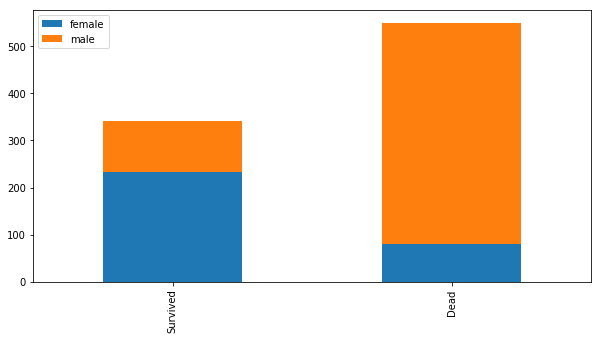

In [391]:
check('Sex')

This chart shows that **women** survived more than **men.**

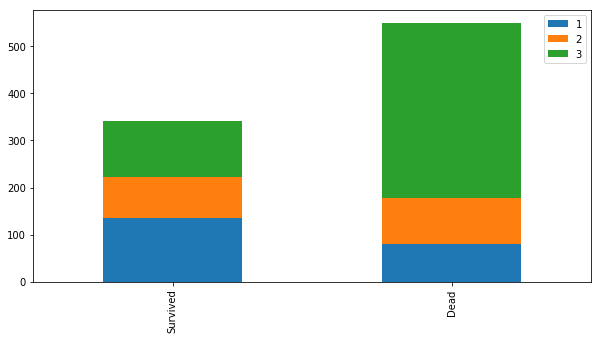

In [392]:
check('Pclass')

This chart shows that the lower the **'pclass'**, the more deaths

And on the contrary, more people of higher pclass survived.

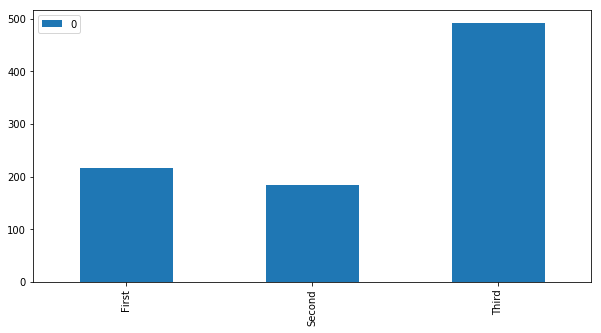

In [393]:
def count_pclass():
    fir = np.asarray(train['Pclass'] == 1).sum()
    sec = np.asarray(train['Pclass'] == 2).sum()
    thir = np.asarray(train['Pclass'] == 3).sum()
    df = pd.DataFrame([fir, sec, thir])
    df.index = ['First','Second','Third']
    df.plot(kind = 'bar', figsize = (10,5))
    
count_pclass()

but you should know, of all passengers, 3 pclass is the most frequent

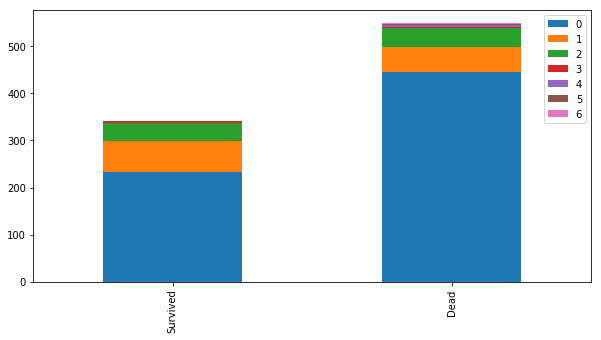

In [394]:
check('Parch')

This chart shows that passengers who aboard a ship alone without their families died more than other passengers.

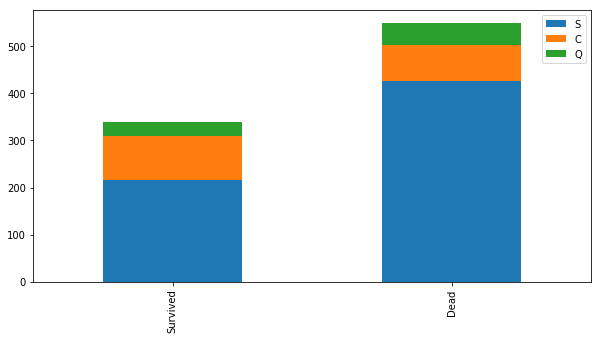

In [395]:
check('Embarked')

Passengers aboard **'Q'** died more than other passengers

hmm, let me guess more of people were aboard from **'Q'** 

check it out

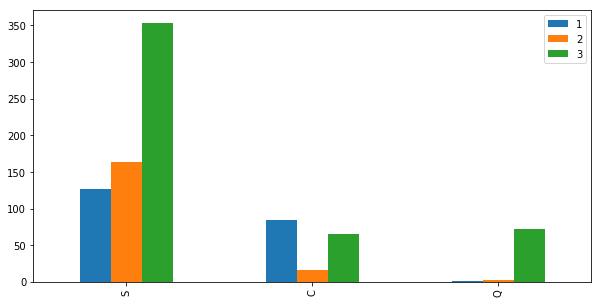

In [396]:
def count():
    S = train[train['Embarked'] == 'S']['Pclass'].value_counts()
    C = train[train['Embarked'] == 'C']['Pclass'].value_counts()
    Q = train[train['Embarked'] == 'Q']['Pclass'].value_counts()
    df = pd.DataFrame([S, C, Q])
    df.index = ['S','C','Q']
    df.plot(kind = 'bar', figsize = (10,5))
    
count()

i got it! , most of people were aboard from **'Q'** and a lot of people aboard from **'Q'** who has class 3

This is the Titanic route. We know where Q, S, C are

<img src = 'titanic-way.jpg'><img>

## Feature engineering
Feature engineering is the process of using domain knowledge of data.
Generates features (feature vectors) that activate machine learning algorithms.

First, combining train and test datas, and we should change name to number

In [397]:
train_test_data = [train, test]
for data in train_test_data:
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

print('In Train data: \n', train['Title'].value_counts())
print('\nIn Test data: \n', test['Title'].value_counts())

In Train data: 
 Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Ms            1
Sir           1
Lady          1
Jonkheer      1
Don           1
Capt          1
Countess      1
Mme           1
Name: Title, dtype: int64

In Test data: 
 Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Dona        1
Ms          1
Name: Title, dtype: int64


In [398]:
train['Title'][:10]

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
5        Mr
6        Mr
7    Master
8       Mrs
9       Mrs
Name: Title, dtype: object

We gonna change Name to Number like this

**Map**

Mr : 0

Miss : 1

Mrs : 2

Others : 3

In [399]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
for data in train_test_data:
    data['Title'] = data['Title'].map(title_mapping)

In [400]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


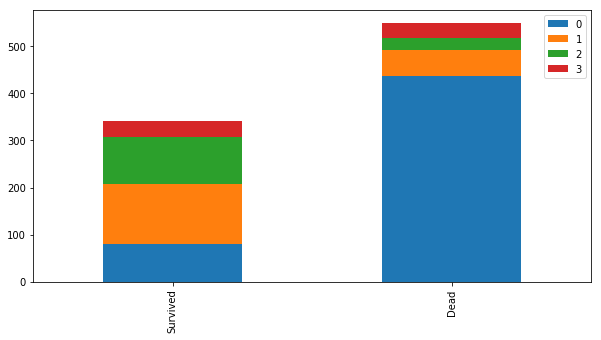

In [401]:
check('Title')

In [402]:
train.drop('Name', axis = 1, inplace = True)

We gonna mapping **embarked and sex ** too 

In [403]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2 }
sex_mapping = {"male": 0, "female": 1,}

for data in train_test_data:
    data['Embarked'] = data['Embarked'].fillna('S')
    data['Embarked'] = data['Embarked'].map(embarked_mapping)
    data['Sex'] = data['Sex'].map(sex_mapping)

In [404]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,1,2
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,0,2
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,0,0


### Fill missing data

first, we know that some of age data is missing, we going to fill missing age data with median age for each title (Mr, Mrs, Miss, etc...)

In [405]:
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

In [406]:
train.head(30)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,1,2
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,0,2
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,0,0
5,6,0,3,0,30.0,0,0,330877,8.4583,NaN,2,0
6,7,0,1,0,54.0,0,0,17463,51.8625,E46,0,0
7,8,0,3,0,2.0,3,1,349909,21.0750,NaN,0,3
8,9,1,3,1,27.0,0,2,347742,11.1333,NaN,0,2
9,10,1,2,1,14.0,1,0,237736,30.0708,NaN,1,2


In [407]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null int64
Title          891 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 83.6+ KB


we also going to mapping to age 

map:

child: 0  

young: 1  

adult: 2  

mid-age: 3  

senior: 4

In [408]:
for dataset in train_test_data:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4    

In [409]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,0,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,0,0


we going to fill missing fare data with median fare for each Pclass

In [410]:
train['Fare'].fillna(train.groupby('Pclass')['Fare'].transform('median'), inplace=True)
test['Fare'].fillna(test.groupby('Pclass')['Fare'].transform('median'), inplace=True)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,0,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,0,0


ok, so we have to fill missing cabin data too

In [411]:
train['Cabin'].value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
C22 C26            3
F33                3
D                  3
E101               3
F2                 3
B58 B60            2
E33                2
C93                2
B57 B59 B63 B66    2
D35                2
D17                2
C126               2
B35                2
D26                2
C124               2
C123               2
E25                2
B49                2
B5                 2
F G73              2
B51 B53 B55        2
B20                2
D36                2
B22                2
E67                2
C65                2
E44                2
                  ..
C111               1
C50                1
A36                1
C45                1
C82                1
E12                1
B80                1
C128               1
B86                1
D19                1
E77                1
B50                1
D47                1
A19                1
B3                 1
C62 C64            1
A10          

In [412]:
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

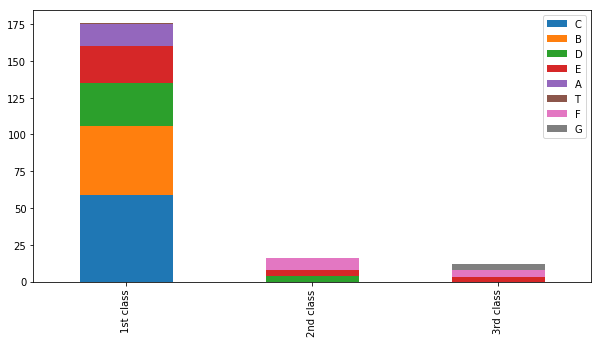

In [413]:
p1 = train[train['Pclass'] == 1]['Cabin'].value_counts()
p2 = train[train['Pclass'] == 2]['Cabin'].value_counts()
p3 = train[train['Pclass'] == 3]['Cabin'].value_counts()
df = pd.DataFrame([p1, p2, p3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

In [414]:
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

Fill missing cabin data with median value for each pclass

In [415]:
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

make family size data using SibSp and Parch

In [416]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

In [417]:
family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
for dataset in train_test_data:
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)

In [418]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,2.0,0,0,0.4
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,0.8,1,2,0.4
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,2.0,0,1,0.0
3,4,1,1,1,2.0,1,0,113803,53.1000,0.8,0,2,0.4
4,5,0,3,0,2.0,0,0,373450,8.0500,2.0,0,0,0.0


## Modeling
i'm gonna using simple linear regression with batch normalization to classification

In [419]:
features_drop = ['Ticket', 'SibSp', 'Parch']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)

In [420]:
Xdata = train.drop('Survived', axis=1)
Ydata = train['Survived']

Xdata.shape, Ydata.shape

((891, 8), (891,))

In [421]:
Xdata = np.array(Xdata)
Ydata = np.array(Ydata)

In [422]:
Ydata = Ydata.reshape(891,1)
Ydata.shape

(891, 1)

### Implement custom Batch Generator 

if you wanna see more about my batch generator 
https://github.com/che9992/BatchGenerator

In [423]:

class BatchGenerator():
    where = 0
    '''
    usage
    
    var = BatchGenerator(xdata, ydata, batch_size = 100)
    var.x 
    var.y
    var.next()
    
    '''
    
    def __init__(self, x, y, batch_size, one_hot = False, nb_classes = 0):
        self.nb_classes = nb_classes
        self.one_hot = one_hot
        self.x_ = x
        self.y_ = y
        self.batch_size = batch_size
        
        self.total_batch = int(len(x) / batch_size)
        self.x = self.x_[:batch_size,:]
        self.y = self.y_[:batch_size,:]
        self.where = batch_size
        
        if self.one_hot :
            self.set_one_hot()

    def next_batch(self):
        if self.where + self.batch_size > len(self.x_) :
            self.where = 0
            
        self.x = self.x_[self.where:self.where+self.batch_size,:]
        self.y = self.y_[self.where:self.where+self.batch_size,:]
        self.where += self.batch_size
        
        if self.one_hot:
            self.set_one_hot()
        
    def set_one_hot(self):
        self.y = np.int32(self.y)
        one_hot = np.array(self.y).reshape(-1)
        self.y = np.eye(self.nb_classes)[one_hot]

Using Batch nomalization before ReLu 

if you wanna see more about BN check it out 

https://github.com/che9992/Batch_Normalization

In [424]:
def TO_FC_BN(X, size, phase, scope):
    with tf.variable_scope(scope):
        fc1 = tf.contrib.layers.fully_connected(X, size, activation_fn=None, scope='fully_connected', reuse=tf.AUTO_REUSE)
        fc2 = tf.contrib.layers.batch_norm(fc1, center = True, scale = True, is_training= phase, scope='bn', reuse=tf.AUTO_REUSE)
        return tf.nn.relu(fc2, name='relu')
    
def FC_2_NC(X, nb_classes, scope):
    return tf.contrib.layers.fully_connected(X, nb_classes, activation_fn=None, scope=scope, reuse=tf.AUTO_REUSE)    

In [425]:
tf.reset_default_graph() 
nb_classes = 2

phase = tf.placeholder(dtype=tf.bool, name = 'phase')
X = tf.placeholder(shape=[None, 8], dtype=tf.float32, name='X')
Y = tf.placeholder(shape=[None, nb_classes], dtype=tf.float32, name='Y')

FC1 = TO_FC_BN(X, 128, phase=phase, scope='layer1')
FC2 = TO_FC_BN(FC1, 256, phase=phase, scope='layer2')
FC3 = TO_FC_BN(FC2, 512, phase=phase, scope='layer3')
FC4 = TO_FC_BN(FC3, 1024, phase=phase, scope='layer4')
FC5 = TO_FC_BN(FC4, 1024, phase=phase, scope='layer5')
FC6 = TO_FC_BN(FC5, 512, phase=phase, scope='layer6')
FC7 = TO_FC_BN(FC6, 512, phase=phase, scope='layer7')
FC8 = TO_FC_BN(FC7, 256, phase=phase, scope='layer8')
logits = FC_2_NC(FC8, nb_classes, scope='logits')


with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('cost'):
     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y))

In [426]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

batch = BatchGenerator(Xdata,Ydata,batch_size=100,nb_classes=2,one_hot=True)
check = BatchGenerator(Xdata,Ydata,batch_size=len(Xdata),nb_classes=2,one_hot=True)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

def train(epochs = 20, batch_size = 200):
 
    for epoch in range(epochs):
        avg_cost = 0
        
        for i in range(batch.total_batch):
            c, _ = sess.run([cost, optimizer], feed_dict= {'X:0': batch.x, 'Y:0': batch.y, 'phase:0': True})
            avg_cost += c / batch.total_batch
            batch.next_batch()
            
        if epoch % 100 == 0:
            print("Epoch:", '%04d,' % (epoch), 'cost = ', '{:.9f}'.format(avg_cost))
            train_acc = sess.run(accuracy,feed_dict={'X:0': check.x, 'Y:0': check.y, 'phase:0': True})
            print('Train Accuracy: {:.2f}% '.format(train_acc * 100))


In [427]:
train(epochs=500, batch_size=400)

Epoch: 0000, cost =  0.597776528
Train Accuracy: 82.49% 
Epoch: 0100, cost =  0.057034051
Train Accuracy: 86.98% 
Epoch: 0200, cost =  0.046485119
Train Accuracy: 87.54% 
Epoch: 0300, cost =  0.041094979
Train Accuracy: 87.65% 
Epoch: 0400, cost =  0.036683603
Train Accuracy: 88.44% 


In [428]:
test = test.drop('Name',axis=1)

In [429]:
test_1 = test.drop('PassengerId',axis=1)

In [430]:
def tesing():
    t = sess.run(tf.argmax(logits, 1), feed_dict={'X:0': test_1, 'phase:0': False})
    return t

In [431]:
result = tesing()

In [432]:
submission = pd.DataFrame({
        "PassengerId": test['PassengerId'],
        "Survived": result
    })

In [433]:
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## Result 

<img src = 'result.png'><img>

## References

This notebook is created by learning from the following notebooks:

https://github.com/minsuk-heo/kaggle-titanic


